# A2. Models of complex networks Assignment

Galata Aglaia-Elli & Kharitonova Ksenia


# Imports

In [10]:
import random
from itertools import combinations
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import numpy as np
from random import choices
import seaborn as sns
import os
from scipy.stats import binom, linregress
from scipy.stats import binom

sns.set()
np.random.seed(0)
sns.set(style="whitegrid")
sns.set_palette("Set3", 10)

# Erdos Renyi G(n, m)

In [11]:
def erdos_renyi_e(n, m):
    '''Creates random Erdos-Renyi graph from n nodes and k edges.
    '''
    G = nx.Graph()
    total_nodes = list(range(n))
    G.add_nodes_from(total_nodes)
    max_edges = n * (n - 1) / 2
    if m == 0:
        return G
    elif m == max_edges:
        G = complete_graph(n, using=G)
        return G
    else:
        total_edges = list(combinations(range(n), 2))
        random_edges = random.sample(total_edges, m)
        G.add_edges_from(random_edges)
    
    
    avg_degree = np.ceil(np.mean([t[1] for t in list(nx.degree(G))]))

    title = "Erdos Renyi G(n, m) with nodes={} and edges={} and mean k={}".format(n, m, avg_degree)
    file = "graphs/Erdos_Renyi_E_n={}_m={}.png".format(n, m)
#     plot_networks(G, title, file)
    return G

# Erdos Renyi G(n, p)

In [12]:
def erdos_renyi_p(n, p):
    '''Creates random Erdos-Renyi graph from n nodes and probability p of forming the edge.
    '''
    G = nx.Graph()
    total_nodes = list(range(n))
    G.add_nodes_from(total_nodes)
    max_edges = n * (n - 1) / 2
    if p == 0:
        return G
    elif p == 1:
        G = complete_graph(n, using=G)
        return G
    else:
        total_edges = list(combinations(range(n), 2))
        m = int(round(p*max_edges,0))
        random_edges = random.sample(total_edges, m)
        G.add_edges_from(random_edges)
    
    avg_degree = np.ceil(np.mean([t[1] for t in list(nx.degree(G))]))
    
    title = "Erdos Renyi G(n, p) with nodes={} and prob={} and mean k={}".format(n, p, int(avg_degree))
    file = "graphs/Erdos_Renyi_P_n={}_p={}.png".format(n, p)
#     plot_networks(G, title, file)
    return G

# Barabasi & Albert

In [13]:
def barabasi_albert(n, m):
    '''Creates Barabasi & alber graph from m average degree of the resulting network.
    '''

    G = nx.Graph()
    # Create a complete graph with a small number of nodes
    if n < m:
        G = nx.complete_graph(n, create_using=G)
        return G
    else:
        G = nx.complete_graph(m, create_using=G)

    for i in range(m, n):
        n_nodes = G.number_of_nodes()
        population = list(range(n_nodes))
        sum_degree = sum([G.degree[node] for node in G.nodes])
        if sum_degree != 0:
            weights = [G.degree[node]/sum_degree for node in G.nodes]
            edges = choices(population, weights, k=m)
            G.add_node(i)
            z = list(zip([i]*m, edges))
            G.add_edges_from(z)
        else:
            G.add_node(i)
            G.add_edges_from([(0, i)])
            
    title = "Barabasi & Alber graph with nodes={} and m={}".format(n, m)
    file = "graphs/Barabasi_Albert_n={}_k={}.png".format(n, m)

#     plot_networks(G, title, file)
    return G

# Plot Networks

In [14]:
def plot_networks(G, title, file):
    f = plt.figure()
    matplotlib.use("Agg")
    nx.draw_networkx(G, with_labels=False,
                     node_size=12,
                     edge_color='r')
    plt.title(title)
    plt.axis('off')

    plt.savefig(file)

# Plot Degree Distributions for Erdos Renyi

### Plot degree distributions for N = 1000, 10000 and p = 0.06123, 0.123, 0.204

In [15]:
erdos_renyi_1000_1 = erdos_renyi_p(1000, 0.06123)
erdos_renyi_1000_2 = erdos_renyi_p(1000, 0.123)
erdos_renyi_1000_3 = erdos_renyi_p(1000, 0.204)

erdos_renyi_10000_1 = erdos_renyi_p(10000, 0.06123)

erdos_renyi_10000_2 = erdos_renyi_p(10000, 0.123)
erdos_renyi_10000_3 = erdos_renyi_p(10000, 0.204)

In [16]:
def plot_er_graph(G, p):
    n_nodes = G.number_of_nodes()
    deg = list(nx.degree(G))
    node_indexes, node_degrees = zip(*deg)

    degrees_th = list(set(node_degrees))
    p_th = [binom.pmf(k, n_nodes - 1, p) for k in degrees_th]
    
    fig = plt.figure()
    plt.hist(node_degrees, density=True, label='empirical')
    plt.plot(degrees_th, p_th, c='r', label='theoretical')
    plt.legend()
    plt.title('Degree distribution of Erdos-Renyi graph with {} nodes and p={}'.format(n_nodes, p))
    plt.savefig("pdfs/Erdos_Renyi_n={}_p={}.png".format(n_nodes, p))
    plt.close
    return fig

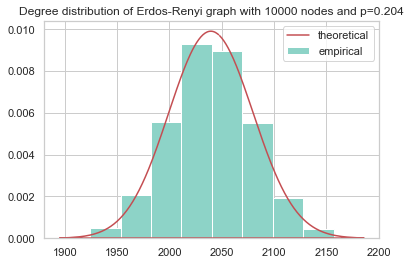

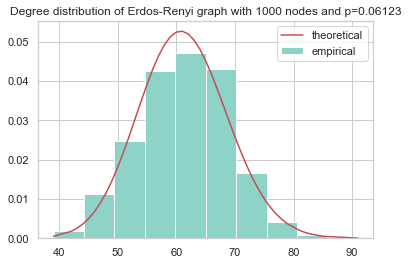

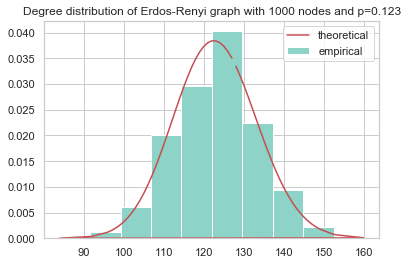

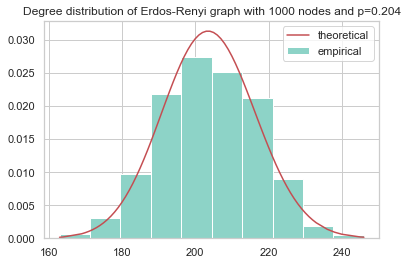

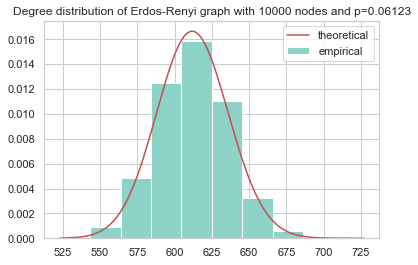

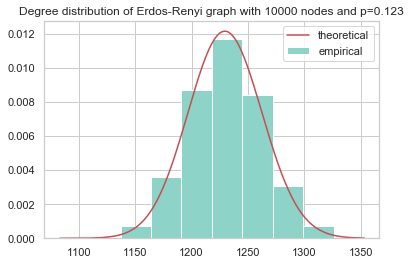

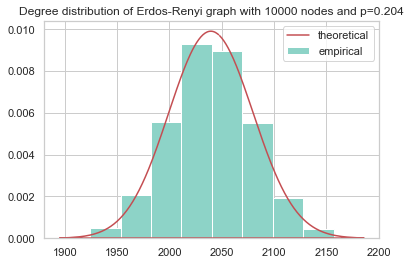

In [17]:
plot_er_graph(erdos_renyi_1000_1, 0.06123)
plot_er_graph(erdos_renyi_1000_2, 0.123)
plot_er_graph(erdos_renyi_1000_3, 0.204)
plot_er_graph(erdos_renyi_10000_1, 0.06123)
plot_er_graph(erdos_renyi_10000_2, 0.123)
plot_er_graph(erdos_renyi_10000_3, 0.204)

# Plot Degree Distributions for Barabasi Albert

In [18]:
def plot_ba_graph(G, k, C):
    n_nodes = G.number_of_nodes()
    deg = list(nx.degree(G))
    node_indexes, node_degrees = zip(*deg)
    fig = plt.figure()
    plt.hist(node_degrees, 10 ** np.linspace(np.log10(min(node_degrees)), np.log10(max(node_degrees)), 20), log=True, density=True, label='empirical')
    plt.plot([10**np.log10(k) for k in list(set(node_degrees))],[C*k**(-3) for k in [10**np.log10(k) for k in list(set(node_degrees))]], c='r', label='theoretical')
    plt.gca().set_xscale("log")
    plt.legend()
    plt.title(f'Power-law degree distribution of PA graph with {n_nodes} nodes and k={k}')
    plt.savefig("pdfs/Barabasi_Albert_n={}_m={}.png".format(n_nodes, k))
    plt.show()
    return fig

### Plot degree distributions for N = 1000, 10000 and m = 1, 2, 5

In [19]:
ba_graph_1000_1 = barabasi_albert(1000,1)
ba_graph_1000_2 = barabasi_albert(1000,2)
ba_graph_1000_5 = barabasi_albert(1000,5)

ba_graph_10000_1 = barabasi_albert(10000,1)
ba_graph_10000_2 = barabasi_albert(10000,2)
ba_graph_10000_5 = barabasi_albert(10000,5)

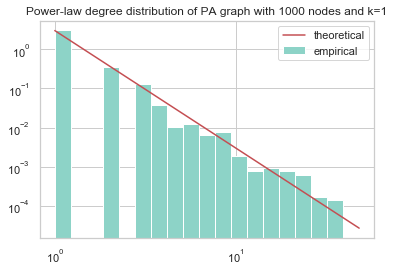

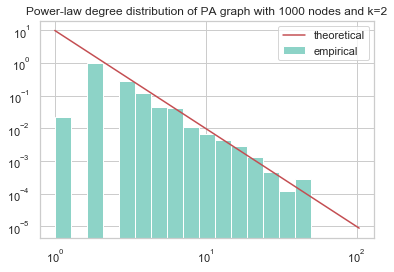

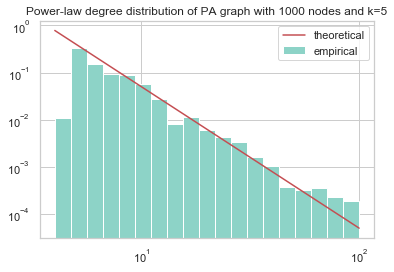

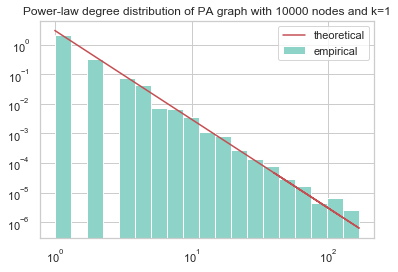

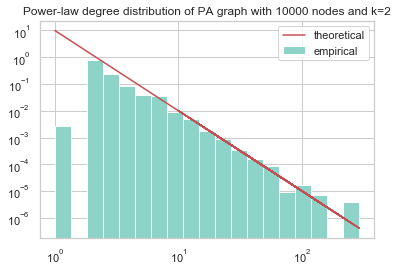

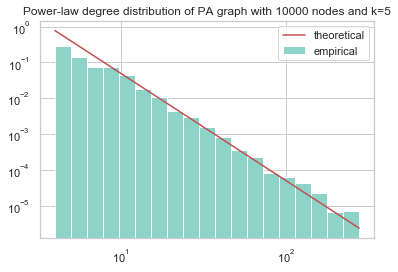

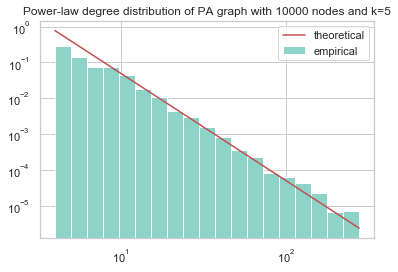

In [22]:
plot_ba_graph(ba_graph_1000_1, 1, 3)
plot_ba_graph(ba_graph_1000_2, 2, 10)
plot_ba_graph(ba_graph_1000_5, 5, 50)
plot_ba_graph(ba_graph_10000_1, 1, 3)
plot_ba_graph(ba_graph_10000_2, 2, 10)
plot_ba_graph(ba_graph_10000_5, 5, 50)

# Estimate Component on Barabasi Albert

In [23]:
def estimate_exponent(G):
    n_nodes = G.number_of_nodes()
    deg = list(nx.degree(G))
    node_indexes, node_degrees = zip(*deg)
    log_degrees = np.array([np.log(k) for k in node_degrees])
    bins = np.linspace(np.log(min(node_degrees)), np.log(max(node_degrees)+1), 11)
    binned_values = []
    for i in range(10):
        binned_values.append(len(log_degrees[(log_degrees>=bins[i]) & (log_degrees<bins[i+1])]))
    prob = np.array(binned_values)/np.sum(binned_values)
    slope, intercept, r_value, p_value, std_err = linregress(bins[:10],np.log(prob))
    return -slope+1

In [24]:
gamma = estimate_exponent(ba_graph_1000_1)
print("BA component for N={} and k={} is {}".format(1000, 1, gamma))

BA component for N=1000 and k=1 is 2.52506873336977


In [25]:
gamma = estimate_exponent(ba_graph_1000_2)
print("BA component for N={} and k={} is {}".format(1000, 2, gamma))

BA component for N=1000 and k=2 is 2.0823928195035366


In [26]:
gamma = estimate_exponent(ba_graph_1000_5)
print("BA component for N={} and k={} is {}".format(1000, 5, gamma))

BA component for N=1000 and k=5 is 2.5538223804913094


In [27]:
gamma = estimate_exponent(ba_graph_10000_1)
print("BA component for N={} and k={} is {}".format(10000, 1, gamma))

BA component for N=10000 and k=1 is 2.7363890090619614


In [28]:
gamma = estimate_exponent(ba_graph_10000_2)
print("BA component for N={} and k={} is {}".format(10000, 2, gamma))

BA component for N=10000 and k=2 is 1.9976957177679733


In [29]:
gamma = estimate_exponent(ba_graph_10000_5)
print("BA component for N={} and k={} is {}".format(10000, 5, gamma))

BA component for N=10000 and k=5 is 2.7374002523650063


# Configuration Model (CN)

In [30]:
def configuration_model(N, distribution, name):
    nodes_list = list(range(N))
    stubs = []

    if sum(distribution)  % 2 != 0:
        a = random.sample(nodes_list, 1)
        distribution[a] +=1

    for degree in distribution:
        stubs.append(0.5*degree)

    total_num_edges = sum(stubs)

    G = nx.Graph()
    G.add_nodes_from(nodes_list)
    for _ in list(range(int(total_num_edges))):
        population = [t for t in nodes_list if distribution[t] > 0]
        
        # check for self-edges
        while len(population) <2:
            edges = random.sample(G.edges(), 1)
            G.remove_edges_from(edges)
            distribution[edges[0][0]] += 1
            distribution[edges[0][1]] += 1
            population = [t for t in nodes_list if distribution[t] > 0]
        node_1, node_2 = random.sample(population, 2)

        # check for double edges
        while (min(node_1, node_2), max(node_1, node_2)) in G.edges():
            possible_edges = list(combinations(population, 2))
            if set(possible_edges).issubset(G.edges()):
                edges = random.sample(G.edges(), 1)
                G.remove_edges_from(edges)
                distribution[edges[0][0]] += 1
                distribution[edges[0][1]] += 1
                population = [t for t in nodes_list if distribution[t] > 0]
            node_1, node_2 = random.sample(population, 2)

        distribution[node_1] -= 1
        distribution[node_2] -= 1
        edge = [(min(node_1, node_2), max(node_1, node_2))]
        G.add_edges_from(edge)
    title = "Configuration model with nodes={} and distribution={}".format(n, name)
    file = "graphs/CM_n={}_name={}.png".format(n, name)
    plot_networks(G, title, file)
    return G


### Generate Power-Law distribution

In [32]:
def power_law_seq(k_min, k_max, y, gamma):
    return ((k_max**(-gamma+1) - k_min**(-gamma+1))*y + k_min**(-gamma+1.0))**(1.0/(-gamma + 1.0))

### Generate Poisson distribution